In [10]:
from google.colab import files
uploaded = files.upload()

Saving emobank.csv to emobank (1).csv


In [11]:
!pip install openpyxl

In [12]:
import os
os.listdir()

['.config', 'emobank.csv', 'app.py', 'emobank (1).csv', 'sample_data']

In [13]:
import pandas as pd

df = pd.read_csv("emobank.csv")
df.head()

,id,split,valence,arousal,dominance,text
0,110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...


In [14]:
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10062 entries, 0 to 10061
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10062 non-null  object 
 1   split      10062 non-null  object 
 2   valence    10062 non-null  float64
 3   arousal    10062 non-null  float64
 4   dominance  10062 non-null  float64
 5   text       10061 non-null  object 
dtypes: float64(3), object(3)
memory usage: 471.8+ KB


Index(['id', 'split', 'valence', 'arousal', 'dominance', 'text'], dtype='object')

In [15]:
!pip install nltk vaderSentiment

In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
try:
    df
except NameError:
    from google.colab import files
    uploaded = files.upload()

    import pandas as pd
    filename = list(uploaded.keys())[0]
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        import openpyxl
        df = pd.read_excel(filename, engine='openpyxl')
    else:
        raise ValueError("Please upload a .csv or .xlsx file.")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

text_col = None
for col in df.columns:
    if 'text' in col.lower() or 'content' in col.lower() or 'sentence' in col.lower():
        text_col = col
        break

if text_col is None:
    raise KeyError("No text-like column found. Please check df.columns and update manually.")

print(f"Using text column: {text_col}")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df[text_col].apply(clean_text)

print("Text cleaned successfully!")
df[[text_col, 'clean_text']].head()

Using text column: text
Text cleaned successfully!


,text,clean_text
0,"Remember what she said in my last letter? """,remember said last letter
1,If I wasn't working here.,working
2,"..""",
3,Goodwill helps people get off of public assist...,goodwill helps people get public assistance
4,Sherry learned through our Future Works class ...,sherry learned future works class could rise m...


In [18]:
!pip install vaderSentiment --quiet

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

print("Sentiment Analysis Completed!")
df[['clean_text', 'sentiment_score', 'sentiment_label']].head()


Sentiment Analysis Completed!


,clean_text,sentiment_score,sentiment_label
0,remember said last letter,0.0000,Neutral
1,working,0.0000,Neutral
2,,0.0000,Neutral
3,goodwill helps people get public assistance,0.3818,Positive
4,sherry learned future works class could rise m...,0.4019,Positive


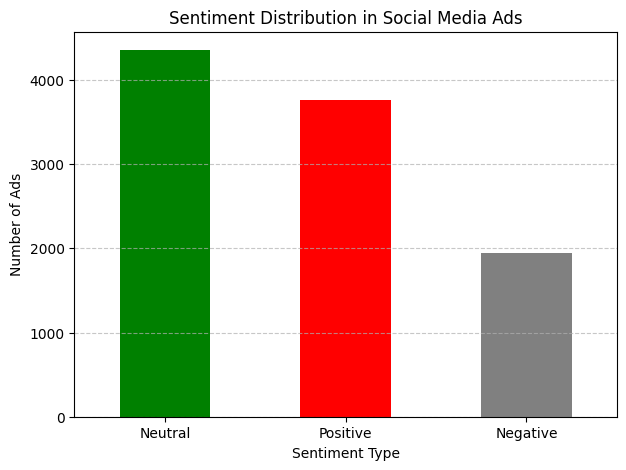

In [19]:
plt.figure(figsize=(7,5))
df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Sentiment Distribution in Social Media Ads")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of Ads")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
import numpy as np

if all(col in df.columns for col in ['valence', 'arousal', 'dominance']):
    df['normalized_valence'] = (df['valence'] - df['valence'].min()) / (df['valence'].max() - df['valence'].min())
    df['normalized_arousal'] = (df['arousal'] - df['arousal'].min()) / (df['arousal'].max() - df['arousal'].min())
    df['normalized_dominance'] = (df['dominance'] - df['dominance'].min()) / (df['dominance'].max() - df['dominance'].min())
else:
    df['normalized_valence'] = abs(df['sentiment_score'])
    df['normalized_arousal'] = abs(df['sentiment_score'])
    df['normalized_dominance'] = abs(df['sentiment_score'])

df['EMI'] = (
    0.5 * abs(df['sentiment_score']) +
    0.3 * df['normalized_arousal'] +
    0.2 * (1 - df['normalized_dominance'])
)

def classify_manipulation(emi):
    if emi >= 0.6:
        return "Highly Manipulative"
    elif emi >= 0.3:
        return "Moderately Manipulative"
    else:
        return "Non-Manipulative"

df['Manipulation_Level'] = df['EMI'].apply(classify_manipulation)

print("Emotional Manipulation Index calculated successfully!")
df[['clean_text', 'sentiment_score', 'EMI', 'Manipulation_Level']].head()


Emotional Manipulation Index calculated successfully!


,clean_text,sentiment_score,EMI,Manipulation_Level
0,remember said last letter,0.0000,0.221106,Non-Manipulative
1,working,0.0000,0.265702,Non-Manipulative
2,,0.0000,0.237635,Non-Manipulative
3,goodwill helps people get public assistance,0.3818,0.410353,Moderately Manipulative
4,sherry learned future works class could rise m...,0.4019,0.431722,Moderately Manipulative


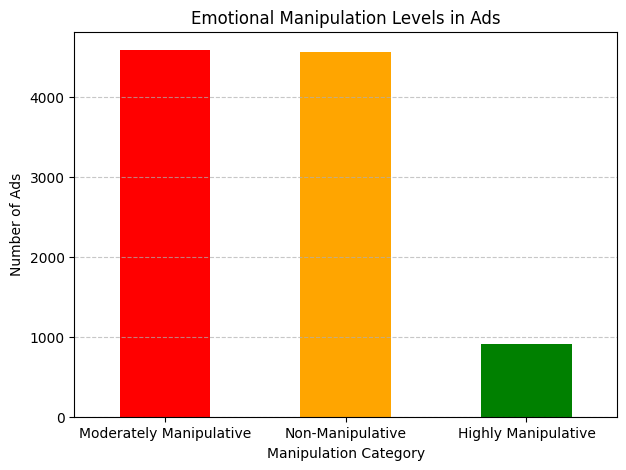

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
df['Manipulation_Level'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Emotional Manipulation Levels in Ads")
plt.xlabel("Manipulation Category")
plt.ylabel("Number of Ads")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.1 MB/s eta 0:00:00


In [23]:
%%writefile app.py
import streamlit as st
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))
analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        label = "Positive"
    elif score <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"
    return score, label

def calculate_emi(score):
    emi = abs(score) * 0.8 + (1 - abs(score)) * 0.2
    if emi >= 0.6:
        level = "Highly Manipulative"
    elif emi >= 0.3:
        level = "Moderately Manipulative"
    else:
        level = "Non-Manipulative"
    return emi, level

st.set_page_config(page_title="Emotional Manipulation Detector", layout="centered")

st.title("Emotional Manipulation Detector")
st.markdown("Detect emotionally manipulative content in social media ads or posts using **NLP + Sentiment Analysis**.")

option = st.radio("Choose Input Type:", ["Single Text", "Upload CSV"])

if option == "Single Text":
    user_input = st.text_area("Enter Advertisement Text:")
    if st.button("Analyze"):
        clean = clean_text(user_input)
        score, label = get_sentiment(clean)
        emi, level = calculate_emi(score)

        st.subheader("Analysis Result")
        st.write(f"**Cleaned Text:** {clean}")
        st.write(f"**Sentiment:** {label}")
        st.write(f"**Sentiment Score:** {score:.2f}")
        st.write(f"**Emotional Manipulation Index (EMI):** {emi:.2f}")
        st.write(f"**Manipulation Level:** {level}")

elif option == "Upload CSV":
    uploaded_file = st.file_uploader("Upload a CSV file", type=["csv"])
    if uploaded_file is not None:
        df = pd.read_csv(uploaded_file)
        if 'text' not in df.columns:
            st.error("CSV must contain a 'text' column.")
        else:
            df['clean_text'] = df['text'].apply(clean_text)
            df['sentiment_score'], df['sentiment_label'] = zip(*df['clean_text'].apply(get_sentiment))
            df['EMI'], df['Manipulation_Level'] = zip(*df['sentiment_score'].apply(calculate_emi))

            st.success("Analysis complete!")
            st.subheader("Results Preview")
            st.dataframe(df[['text', 'sentiment_label', 'sentiment_score', 'EMI', 'Manipulation_Level']])

            st.subheader("Manipulation Level Distribution")
            st.bar_chart(df['Manipulation_Level'].value_counts())
            csv = df.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="⬇Download Results as CSV",
                data=csv,
                file_name="manipulation_results.csv",
                mime="text/csv"
            )


Overwriting app.py


In [28]:
from pyngrok import ngrok
!ngrok authtoken 34eOp7VZ4hFNHPm4QpnIRP4n2rc_5FAEGr9LqAcARdCewZsm

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [29]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null&
url = ngrok.connect(8501)
url

<NgrokTunnel: "https://splintery-fritz-bona.ngrok-free.dev" -> "http://localhost:8501">